# Augmented Neural ODE for Cloud Microphysics

This notebook implements **Augmented Neural ODEs** ([Dupont et al. 2019](https://github.com/EmilienDupont/augmented-neural-odes)) for cloud microphysics modeling.


In [1]:
!pip install torchdiffeq

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint

import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Hyperparameters
config = {
    # Model architecture
    'input_dim': 4,              # Physical dimensions (qc, nc, qr, nr)
    'augment_dim': 1,            # Number of augmented dimensions (start with 1, try 2-3)
    'hidden_size': 50,           # Neurons per hidden layer
    'n_layers': 3,               # Number of hidden layers
    
    # Training
    'dt': 20.0,                  # Time step in seconds
    'batch_size': 4,             # Trajectories per batch
    'learning_rate': 1e-4,       # Adam learning rate
    'n_epochs': 100,             # Training epochs
    'val_every': 3,              # Validation frequency
    'max_grad_norm': 1.0,        # Gradient clipping threshold
    
    # ODE solver
    'ode_solver': 'rk4',         # Choose: 'rk4' or 'dopri5'
    'rtol': 1e-4,                # Relative tolerance (only for adaptive solvers)
    'atol': 1e-6,                # Absolute tolerance (only for adaptive solvers)
}

# Data paths
data_dir = Path('/home/jovyan/cloud_microphysics/data/')
train_path = data_dir / 'train_trajectories.pkl'
val_path = data_dir / 'val_trajectories.pkl'
stats_path = data_dir / 'moment_normalization_stats.pkl'

print(f"\nConfiguration:")
print(f"  Physical dimensions: {config['input_dim']}")
print(f"  Augmented dimensions: {config['augment_dim']}")
print(f"  Total ODE dimensions: {config['input_dim'] + config['augment_dim']}")
print(f"  Hidden size: {config['hidden_size']}")
print(f"  ODE solver: {config['ode_solver']}")


Configuration:
  Physical dimensions: 4
  Augmented dimensions: 1
  Total ODE dimensions: 5
  Hidden size: 50
  ODE solver: rk4


In [4]:
# Load preprocessed trajectories
with open(train_path, 'rb') as f:
    train_trajectories = pickle.load(f)

with open(val_path, 'rb') as f:
    val_trajectories = pickle.load(f)

with open(stats_path, 'rb') as f:
    norm_stats = pickle.load(f)

print(f"\nLoaded {len(train_trajectories)} training trajectories")
print(f"Loaded {len(val_trajectories)} validation trajectories")
print(f"\nNormalization stats loaded: {list(norm_stats.keys())}")

# Inspect sample trajectory
sample_traj = train_trajectories[0]
print(f"\nSample trajectory keys: {list(sample_traj.keys())}")
print(f"Moments shape: {sample_traj['moments_scaled'].shape}")
print(f"Trajectory length: {sample_traj['length']}")


Loaded 575 training trajectories
Loaded 144 validation trajectories

Normalization stats loaded: ['asinh_scales', 'moment_scaler_mean', 'moment_scaler_std', 'moment_scaler']

Sample trajectory keys: ['moments', 'length', 'ic_idx', 'moments_scaled']
Moments shape: (174, 4)
Trajectory length: 174


/srv/conda/envs/notebook/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
class TrajectoryDataset(Dataset):
    """Dataset for trajectory prediction with variable-length sequences.
    
    Returns:
        Dictionary containing:
            - initial_state: (4,) tensor - Initial moment values
            - trajectory: (length, 4) tensor - Full trajectory (variable length)
            - length: int - Number of timesteps in this trajectory
    """
    
    def __init__(self, trajectories, max_timesteps=None):
        """
        Args:
            trajectories: List of trajectory dictionaries
            max_timesteps: Optional maximum timesteps (for capping very long trajectories)
        """
        self.trajectories = trajectories
        self.max_timesteps = max_timesteps
    
    def __len__(self):
        return len(self.trajectories)
    
    def __getitem__(self, idx):
        traj = self.trajectories[idx]
        
        # Get scaled moments and actual length
        moments_scaled = traj['moments_scaled']
        length = traj['length']
        
        # Optionally cap at max_timesteps
        if self.max_timesteps:
            length = min(length, self.max_timesteps)
            moments_scaled = moments_scaled[:length]
        
        # Initial state
        initial_state = moments_scaled[0]  # (4,)
        
        # Full trajectory
        trajectory = moments_scaled  # (length, 4)
        
        return {
            'initial_state': torch.tensor(initial_state, dtype=torch.float32),
            'trajectory': torch.tensor(trajectory, dtype=torch.float32),
            'length': length
        }


def collate_variable_length(batch):
    """Collate function to pad variable-length sequences and create masks.
    
    Args:
        batch: List of dictionaries from TrajectoryDataset
    
    Returns:
        Dictionary containing:
            - initial_states: (batch_size, 4) tensor
            - trajectories: (batch_size, max_len, 4) tensor (padded)
            - masks: (batch_size, max_len) bool tensor (True = valid, False = padded)
            - lengths: (batch_size,) tensor of actual lengths
    """
    lengths = [item['length'] for item in batch]
    max_len = max(lengths)
    batch_size = len(batch)
    
    # Initialize padded tensors
    padded_trajectories = torch.zeros(batch_size, max_len, 4)
    initial_states = torch.stack([item['initial_state'] for item in batch])
    
    # Create mask (True = valid, False = padded)
    mask = torch.zeros(batch_size, max_len, dtype=torch.bool)
    
    # Fill in actual data and mask
    for i, item in enumerate(batch):
        length = item['length']
        padded_trajectories[i, :length] = item['trajectory']
        mask[i, :length] = True
    
    return {
        'initial_states': initial_states,
        'trajectories': padded_trajectories,
        'masks': mask,
        'lengths': torch.tensor(lengths, dtype=torch.long)
    }


def masked_mse_loss(predictions, targets, mask):
    """Compute MSE loss only on valid (non-padded) timesteps.
    
    Args:
        predictions: (batch_size, n_timesteps, 4) tensor
        targets: (batch_size, n_timesteps, 4) tensor
        mask: (batch_size, n_timesteps) bool tensor (True = valid)
    
    Returns:
        Scalar loss value
    """
    # Expand mask to match feature dimension
    mask = mask.unsqueeze(-1)  # (batch_size, n_timesteps, 1)
    
    # Compute squared errors
    squared_errors = (predictions - targets) ** 2  # (batch_size, n_timesteps, 4)
    
    # Apply mask and compute mean over valid elements only
    masked_errors = squared_errors * mask
    loss = masked_errors.sum() / mask.sum()
    
    return loss


# Create datasets (no truncation - use all available timesteps)
train_dataset = TrajectoryDataset(train_trajectories, max_timesteps=None)
val_dataset = TrajectoryDataset(val_trajectories, max_timesteps=None)

# Create dataloaders with custom collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    drop_last=True,
    collate_fn=collate_variable_length
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=collate_variable_length
)

print(f"\nDataset statistics:")
print(f"Training trajectories: {len(train_dataset)}")
print(f"Validation trajectories: {len(val_dataset)}")

# Show trajectory length distribution
train_lengths = [traj['length'] for traj in train_trajectories]
val_lengths = [traj['length'] for traj in val_trajectories]
print(f"\nTraining trajectory lengths:")
print(f"  Min: {min(train_lengths)}, Max: {max(train_lengths)}, Mean: {np.mean(train_lengths):.1f}")
print(f"Validation trajectory lengths:")
print(f"  Min: {min(val_lengths)}, Max: {max(val_lengths)}, Mean: {np.mean(val_lengths):.1f}")


Dataset statistics:
Training trajectories: 575
Validation trajectories: 144

Training trajectory lengths:
  Min: 59, Max: 3599, Mean: 459.2
Validation trajectory lengths:
  Min: 59, Max: 2399, Mean: 448.5


## Augmented Neural ODE Model

1. **AugmentedODEFunc**: Operates on (input_dim + augment_dim) dimensions
2. **augment_initial_state()**: Zero-pads initial states before integration
3. **extract_physical_dims()**: Extracts only physical dimensions after integration

In [ ]:
class AugmentedODEFunc(nn.Module):
    """Neural network that defines the derivative function for augmented state.
    
    Architecture: (input_dim + augment_dim) → hidden → ... → hidden → (input_dim + augment_dim)
    """
    
    def __init__(self, input_dim=4, augment_dim=1, hidden_size=50, n_layers=3):
        super(AugmentedODEFunc, self).__init__()
        
        self.input_dim = input_dim
        self.augment_dim = augment_dim
        self.total_dim = input_dim + augment_dim
        
        layers = []
        
        # Input layer: total_dim → hidden_size
        layers.append(nn.Linear(self.total_dim, hidden_size))
        layers.append(nn.Tanh())
        
        # Hidden layers: hidden_size → hidden_size
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        
        # Output layer: hidden_size → total_dim
        layers.append(nn.Linear(hidden_size, self.total_dim))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, y):
        """
        Args:
            t: Scalar time (required by odeint, but not used for time-invariant dynamics)
            y: State tensor of shape (batch_size, input_dim + augment_dim)
        
        Returns:
            dy/dt: Derivative tensor of shape (batch_size, input_dim + augment_dim)
        """
        return self.net(y)


def augment_initial_state(initial_states, augment_dim, device):
    """Augment initial states with zeros in extra dimensions.
    
    Args:
        initial_states: (batch_size, input_dim) tensor - Physical initial conditions
        augment_dim: Number of augmented dimensions to add
        device: Device to place augmented tensor on
    
    Returns:
        (batch_size, input_dim + augment_dim) tensor - Augmented initial states
    """
    batch_size = initial_states.shape[0]
    aug_zeros = torch.zeros(batch_size, augment_dim, device=device)
    return torch.cat([initial_states, aug_zeros], dim=1)


def extract_physical_dims(augmented_trajectory, input_dim):
    """Extract only the physical dimensions from augmented trajectory.
    
    Args:
        augmented_trajectory: (n_timesteps, batch_size, input_dim + augment_dim) tensor
        input_dim: Number of physical dimensions
    
    Returns:
        (n_timesteps, batch_size, input_dim) tensor - Physical dimensions only
    """
    return augmented_trajectory[:, :, :input_dim]


class AugmentedNeuralODE(nn.Module):
    """Wrapper class that integrates the augmented ODE using torchdiffeq."""
    
    def __init__(self, ode_func, input_dim, augment_dim, method='dopri5', rtol=1e-4, atol=1e-6):
        """
        Args:
            ode_func: AugmentedODEFunc instance
            input_dim: Number of physical dimensions
            augment_dim: Number of augmented dimensions
            method: ODE solver method ('rk4' or 'dopri5')
            rtol: Relative tolerance for adaptive solvers (ignored for rk4)
            atol: Absolute tolerance for adaptive solvers (ignored for rk4)
        """
        super(AugmentedNeuralODE, self).__init__()
        self.ode_func = ode_func
        self.input_dim = input_dim
        self.augment_dim = augment_dim
        self.method = method
        self.rtol = rtol
        self.atol = atol
    
    def forward(self, initial_state, t_span):
        """
        Args:
            initial_state: Tensor of shape (batch_size, input_dim) - Physical initial conditions
            t_span: Tensor of time points to evaluate, shape (n_timesteps,)
        
        Returns:
            trajectory: Tensor of shape (n_timesteps, batch_size, input_dim) - Physical dimensions only
        """
        device = initial_state.device
        
        # Augment initial state with zeros
        initial_state_aug = augment_initial_state(initial_state, self.augment_dim, device)
        
        # Integrate augmented ODE
        if self.method == 'rk4':
            trajectory_aug = odeint(
                self.ode_func,
                initial_state_aug,
                t_span,
                method=self.method
            )
        else:
            trajectory_aug = odeint(
                self.ode_func,
                initial_state_aug,
                t_span,
                method=self.method,
                rtol=self.rtol,
                atol=self.atol
            )
        
        # Extract only physical dimensions for output
        trajectory = extract_physical_dims(trajectory_aug, self.input_dim)
        
        return trajectory

In [ ]:
# Initialize model
ode_func = AugmentedODEFunc(
    input_dim=config['input_dim'],
    augment_dim=config['augment_dim'],
    hidden_size=config['hidden_size'],
    n_layers=config['n_layers']
).to(device)

model = AugmentedNeuralODE(
    ode_func,
    input_dim=config['input_dim'],
    augment_dim=config['augment_dim'],
    method=config['ode_solver'],
    rtol=config['rtol'],
    atol=config['atol']
).to(device)

# Count parameters
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model initialized with {n_params:,} trainable parameters")

# Print solver info
if config['ode_solver'] == 'rk4':
    print(f"\nODE Solver: {config['ode_solver']} (fixed-step, dt={config['dt']}s)")
else:
    print(f"\nODE Solver: {config['ode_solver']} (adaptive, rtol={config['rtol']}, atol={config['atol']})")

print(f"\nModel architecture:")
print(model.ode_func.net)

Model initialized with 5,655 trainable parameters
  (Baseline with augment_dim=0 has 5,554 parameters)

ODE Solver: rk4 (fixed-step, dt=20.0s)

Model architecture:
Sequential(
  (0): Linear(in_features=5, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): Tanh()
  (6): Linear(in_features=50, out_features=5, bias=True)
)


In [8]:
# Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'epochs': []
}

In [ ]:
# Checkpoint settings
RESUME_TRAINING = True  # Set to True to continue from checkpoint
CHECKPOINT_PATH = 'best_model_augmented.pt'  # Path to best model checkpoint file
RESUME_CHECKPOINT_PATH = 'checkpoint_resume_augmented.pt'  # Path to resume checkpoint

# Initialize training variables
start_epoch = 0
best_val_loss = float('inf')

# Try to load resume checkpoint first (most recent), then fall back to best model
checkpoint_to_load = None
if RESUME_TRAINING:
    if Path(RESUME_CHECKPOINT_PATH).exists():
        checkpoint_to_load = RESUME_CHECKPOINT_PATH
        print(f"Found resume checkpoint: {RESUME_CHECKPOINT_PATH}")
    elif Path(CHECKPOINT_PATH).exists():
        checkpoint_to_load = CHECKPOINT_PATH
        print(f"Found best model checkpoint: {CHECKPOINT_PATH}")
    else:
        print(f"WARNING: RESUME_TRAINING=True but no checkpoint found")

# Load checkpoint if available
if checkpoint_to_load:
    print(f"Loading checkpoint from {checkpoint_to_load}...")
    checkpoint = torch.load(checkpoint_to_load, map_location=device, weights_only=False)
    
    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Load training progress
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint.get('best_val_loss', checkpoint.get('val_loss', float('inf')))
    
    # Load history if available
    if 'history' in checkpoint:
        history = checkpoint['history']
        print(f"Loaded training history with {len(history['train_loss'])} epochs")
    
    print(f"Resuming from Checkpoint")
    print(f"  Epoch: {checkpoint['epoch']}")
    if 'train_loss' in checkpoint:
        print(f"  Train Loss: {checkpoint['train_loss']:.6f}")
    print(f"  Val Loss: {checkpoint['val_loss']:.6f}")
    print(f"  Best Val Loss: {best_val_loss:.6f}")
    print(f"  Config: {checkpoint['config']}")
    print(f"\nWill continue training from epoch {start_epoch + 1} to {config['n_epochs']}")
        
else:
    print(f"Starting fresh training for {config['n_epochs']} epochs")
    print(f"Best model will be saved to: {CHECKPOINT_PATH}")
    print(f"Resume checkpoints will be saved to: {RESUME_CHECKPOINT_PATH}")

Starting fresh training for 100 epochs
Model will be saved to: best_model_augmented.pt


In [10]:
def train_epoch(model, train_loader, optimizer, device, dt=20.0):
    """Train for one epoch with variable-length sequences."""
    model.train()
    total_loss = 0.0
    n_nan_batches = 0
    
    for batch in tqdm(train_loader, desc='Training', leave=False):
        initial_states = batch['initial_states'].to(device)  # (batch_size, 4)
        target_trajectories = batch['trajectories'].to(device)  # (batch_size, max_len, 4)
        masks = batch['masks'].to(device)  # (batch_size, max_len)
        
        # Create dynamic t_span for this batch based on max length
        max_len = target_trajectories.shape[1]
        t_span = torch.arange(0, max_len, dtype=torch.float32, device=device) * dt
        
        # Forward pass: integrate ODE
        # Note: model handles augmentation internally and returns only physical dimensions
        pred_trajectory = model(initial_states, t_span)  # (max_len, batch_size, 4)
        
        # Reshape: (max_len, batch_size, 4) -> (batch_size, max_len, 4)
        pred_trajectory = pred_trajectory.permute(1, 0, 2)
        
        # Check for NaN/Inf in predictions
        if torch.isnan(pred_trajectory).any() or torch.isinf(pred_trajectory).any():
            print(f"\nWARNING: NaN/Inf detected in predictions! Skipping batch.")
            n_nan_batches += 1
            continue
        
        # Compute masked loss (only on valid timesteps)
        loss = masked_mse_loss(pred_trajectory, target_trajectories, masks)
        
        # Check for NaN/Inf in loss
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"\nWARNING: NaN/Inf loss detected! Skipping batch.")
            n_nan_batches += 1
            continue
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config['max_grad_norm'])
        
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / max(len(train_loader) - n_nan_batches, 1)
    if n_nan_batches > 0:
        print(f"\nSkipped {n_nan_batches}/{len(train_loader)} batches due to NaN/Inf")
    return avg_loss


def validate(model, val_loader, device, dt=20.0):
    """Validate the model with variable-length sequences."""
    model.eval()
    total_loss = 0.0
    n_nan_batches = 0
    
    with torch.no_grad():
        for batch in val_loader:
            initial_states = batch['initial_states'].to(device)
            target_trajectories = batch['trajectories'].to(device)
            masks = batch['masks'].to(device)
            
            # Create dynamic t_span for this batch
            max_len = target_trajectories.shape[1]
            t_span = torch.arange(0, max_len, dtype=torch.float32, device=device) * dt
            
            # Forward pass
            pred_trajectory = model(initial_states, t_span)
            pred_trajectory = pred_trajectory.permute(1, 0, 2)
            
            # Check for NaN/Inf
            if torch.isnan(pred_trajectory).any() or torch.isinf(pred_trajectory).any():
                n_nan_batches += 1
                continue
            
            # Compute masked loss
            loss = masked_mse_loss(pred_trajectory, target_trajectories, masks)
            if not (torch.isnan(loss) or torch.isinf(loss)):
                total_loss += loss.item()
            else:
                n_nan_batches += 1
    
    avg_loss = total_loss / max(len(val_loader) - n_nan_batches, 1)
    if n_nan_batches > 0:
        print(f"  Validation: Skipped {n_nan_batches}/{len(val_loader)} batches due to NaN/Inf")
    return avg_loss

## Training

In [11]:
# Training loop
print(f"\nStarting training from epoch {start_epoch + 1}...\n")

for epoch in range(start_epoch, config['n_epochs']):
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, device, dt=config['dt'])
    history['train_loss'].append(train_loss)
    
    # Validate
    if (epoch + 1) % config['val_every'] == 0:
        val_loss = validate(model, val_loader, device, dt=config['dt'])
        history['val_loss'].append(val_loss)
        history['epochs'].append(epoch + 1)
        
        print(f"Epoch {epoch+1}/{config['n_epochs']} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'train_loss': train_loss,
                'config': config,
                'history': history
            }, CHECKPOINT_PATH)
            print(f"  → Saved best model (val_loss: {val_loss:.6f})")
        
        # Save regular checkpoint for resuming (every validation step)
        checkpoint_resume_path = 'checkpoint_resume_augmented.pt'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'train_loss': train_loss,
            'config': config,
            'history': history,
            'best_val_loss': best_val_loss
        }, checkpoint_resume_path)
        print(f"  → Saved resume checkpoint at epoch {epoch + 1}")
        
    else:
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{config['n_epochs']} - Train Loss: {train_loss:.6f}")

print(f"\nTraining complete! Best validation loss: {best_val_loss:.6f}")
print(f"Trained for {len(history['train_loss'])} total epochs")


Starting training from epoch 1...



Epoch 3/100 - Train Loss: 4.506633, Val Loss: 4.439059
  → Saved best model (val_loss: 4.439059)


Epoch 6/100 - Train Loss: 4.407577, Val Loss: 4.425924
  → Saved best model (val_loss: 4.425924)


Epoch 9/100 - Train Loss: 4.457912, Val Loss: 5.373732


Epoch 10/100 - Train Loss: 4.428843


Epoch 12/100 - Train Loss: 4.746804, Val Loss: 5.289624


Epoch 15/100 - Train Loss: 4.471233, Val Loss: 4.513764


Epoch 18/100 - Train Loss: 4.512253, Val Loss: 4.352952
  → Saved best model (val_loss: 4.352952)


Epoch 20/100 - Train Loss: 4.364294


Epoch 21/100 - Train Loss: 4.340717, Val Loss: 4.685617


Epoch 24/100 - Train Loss: 4.320350, Val Loss: 3.263411
  → Saved best model (val_loss: 3.263411)


Epoch 27/100 - Train Loss: 4.268930, Val Loss: 4.057262


Epoch 30/100 - Train Loss: 4.240009, Val Loss: 5.211246


Epoch 33/100 - Train Loss: 4.198054, Val Loss: 4.880457


Epoch 36/100 - Train Loss: 4.943566, Val Loss: 6.609077


Epoch 39/100 - Train Loss: 4.385113, Val Loss: 3.972442


Epoch 40/100 - Train Loss: 4.415221


Epoch 42/100 - Train Loss: 4.284741, Val Loss: 4.022587


KeyboardInterrupt: 

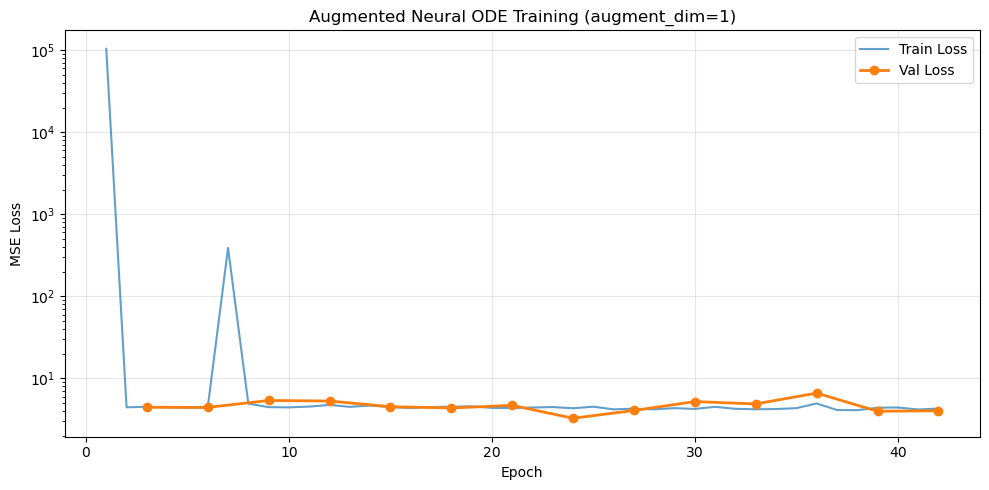

Final train loss: 4.284741
Final val loss: 4.022587
Best val loss: 3.263411


In [14]:
# Plot training curves
fig, ax = plt.subplots(figsize=(10, 5))

# Train loss
ax.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], 
        label='Train Loss', alpha=0.7)

# Val loss
ax.plot(history['epochs'], history['val_loss'], 
        label='Val Loss', marker='o', linewidth=2)

ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title(f'Augmented Neural ODE Training (augment_dim={config["augment_dim"]})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"Final train loss: {history['train_loss'][-1]:.6f}")
print(f"Final val loss: {history['val_loss'][-1]:.6f}")
print(f"Best val loss: {best_val_loss:.6f}")

## Model Evaluation

In [15]:
# Load best model checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']} (val_loss: {checkpoint['val_loss']:.6f})")

Loaded best model from epoch 24 (val_loss: 3.263411)


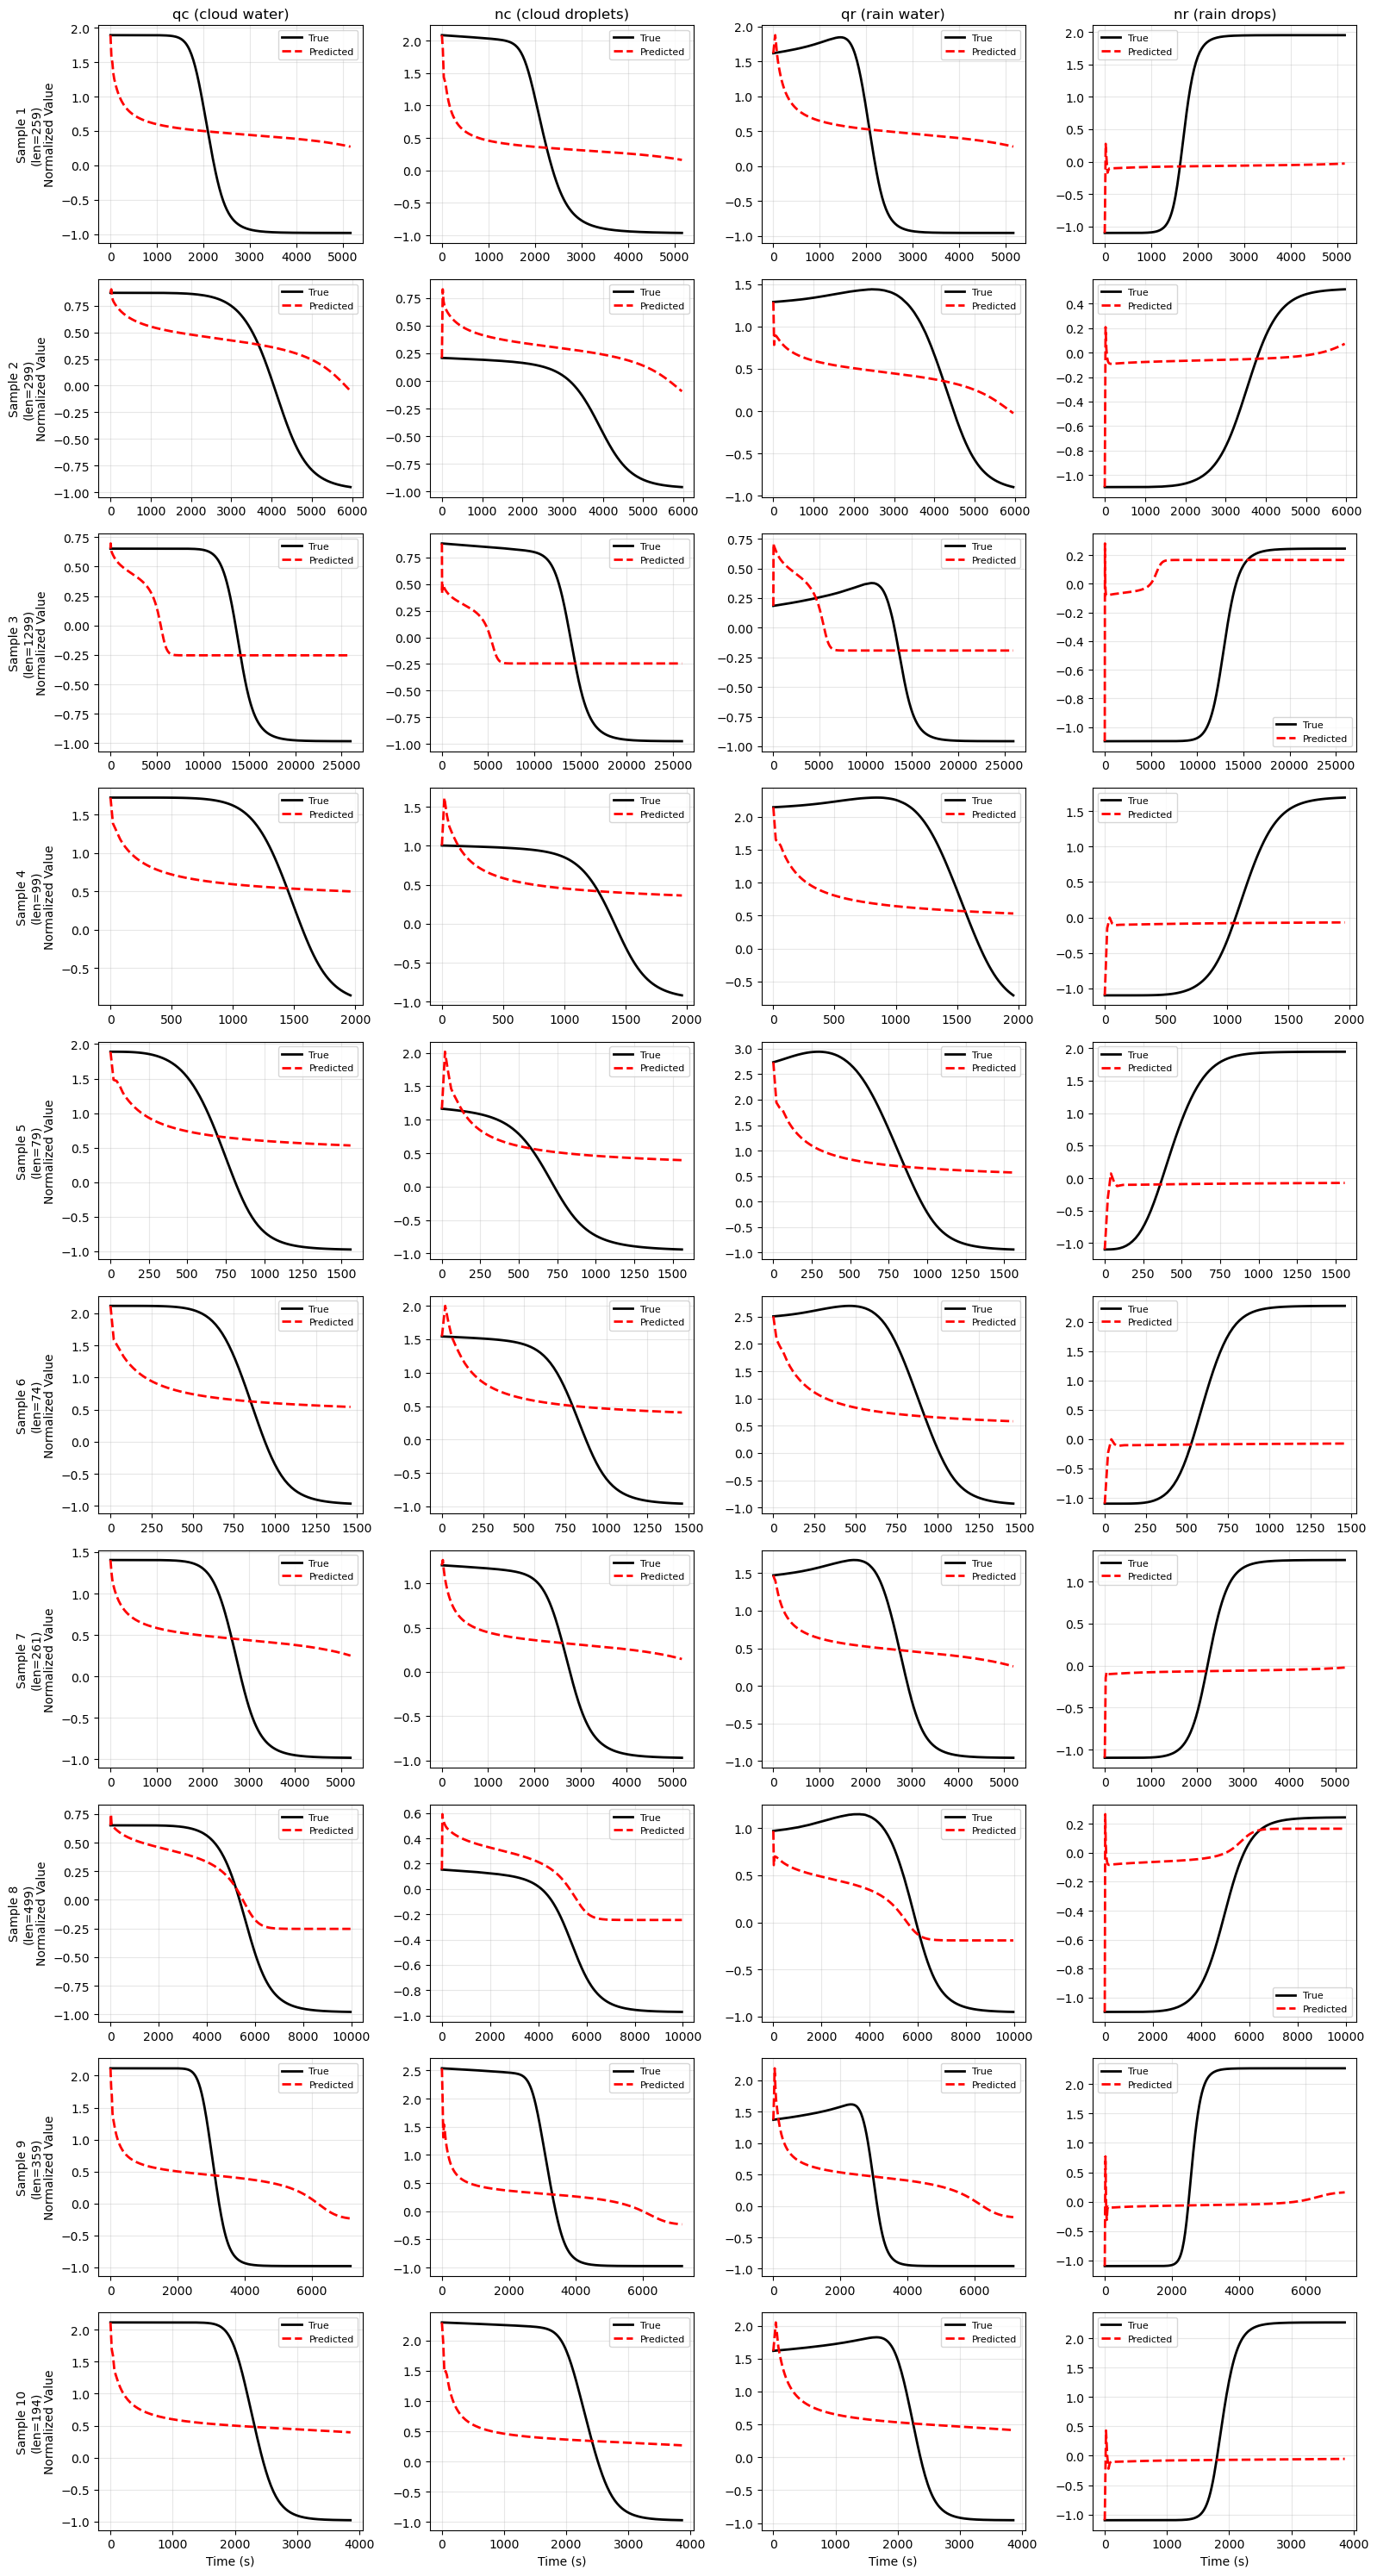

In [16]:
# Select validation samples to visualize
n_samples = 10
sample_indices = np.random.choice(len(val_dataset), n_samples, replace=False)

# Moment names
moment_names = ['qc (cloud water)', 'nc (cloud droplets)', 'qr (rain water)', 'nr (rain drops)']

# Create subplots
fig, axes = plt.subplots(n_samples, 4, figsize=(16, 3*n_samples))
if n_samples == 1:
    axes = axes[np.newaxis, :]

with torch.no_grad():
    for i, sample_idx in enumerate(sample_indices):
        # Get data
        sample = val_dataset[sample_idx]
        initial_state = sample['initial_state'].unsqueeze(0).to(device)  # (1, 4)
        target_trajectory = sample['trajectory'].cpu().numpy()  # (length, 4)
        length = sample['length']
        
        # Create t_span for this specific trajectory
        t_span_sample = torch.arange(0, length, dtype=torch.float32, device=device) * config['dt']
        
        # Predict
        pred_trajectory = model(initial_state, t_span_sample)  # (length, 1, 4)
        pred_trajectory = pred_trajectory.squeeze(1).cpu().numpy()  # (length, 4)
        
        # Time axis
        time_axis = t_span_sample.cpu().numpy()
        
        # Plot each moment
        for j in range(4):
            ax = axes[i, j]
            ax.plot(time_axis, target_trajectory[:, j], 'k-', label='True', linewidth=2)
            ax.plot(time_axis, pred_trajectory[:, j], 'r--', label='Predicted', linewidth=2)
            
            if i == 0:
                ax.set_title(moment_names[j], fontsize=12)
            if i == n_samples - 1:
                ax.set_xlabel('Time (s)', fontsize=10)
            if j == 0:
                ax.set_ylabel(f'Sample {i+1}\n(len={length})\nNormalized Value', fontsize=10)
            
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()